In [1]:
# Import necessary libraries. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras as keras
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

## Import the Obesity Dataset

In [2]:
# Importing the dataset and data preview.
obesity_data = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv", delimiter=",")

# Print the Table
obesity_data.head(15)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


## Check the datatype and convert them into correct datatype

In [3]:
# Display the data types of each column in the dataset
print(obesity_data.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


In [4]:
# Convert FCVC and TUE to integers
X = obesity_data.drop(columns=['NObeyesdad']).copy()
X['FCVC'] = X['FCVC'].astype(int)
X['TUE'] = X['TUE'].astype(int)

# Separate target variable
y = obesity_data['NObeyesdad']

# Check the data types again
print(X.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                                int32
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                                 int32
CALC                               object
MTRANS                             object
dtype: object


## Split training, validation, and test dataset

In [5]:
# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Standardize continuous features and encode categorical features

In [6]:
# Convert binary features from "yes"/"no" to 1/0 in the training, validation, and test sets
binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for feature in binary_features:
    X_train[feature] = X_train[feature].map({'yes': 1, 'no': 0})
    X_val[feature] = X_val[feature].map({'yes': 1, 'no': 0})
    X_test[feature] = X_test[feature].map({'yes': 1, 'no': 0})

# Sample columns based on data type
continuous_features = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF']
integer_features_to_encode = ['TUE', 'FCVC']  # Only apply OneHotEncoder to FCVC and TUE
categorical_features = ['Gender', 'CAEC', 'CALC', 'MTRANS']

# Define ColumnTransformer with the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', StandardScaler(), continuous_features),  # Standardize continuous features
        ('binary', 'passthrough', binary_features),  # Binary features are already in 0/1 format
        ('integer_encode', OneHotEncoder(sparse_output=False), integer_features_to_encode),  # One-hot encode integer features
        ('categorical', OneHotEncoder(sparse_output=False), categorical_features)  # One-hot encode categorical features
    ])

# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test sets using the preprocessor
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Check shapes to confirm transformations
print("Train shape:", X_train_transformed.shape)
print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)


Train shape: (1266, 31)
Validation shape: (422, 31)
Test shape: (423, 31)


In [7]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

## Set up the model

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# Define the model (Using Selu activation for the input and hidden layers, he normalization kernel initializer, and softmax for the output layer)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='selu', input_shape=(31,), kernel_regularizer=l2(0.001),
                          ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.001),
                          ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='selu', kernel_regularizer=l2(0.001),
                          ),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, 
                    epochs=120, 
                    batch_size=32, 
                    validation_data=(X_val_transformed, y_val))

Epoch 1/120


C:\Users\valha\anaconda3\envs\stat_479\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1716 - loss: 3.4009 - val_accuracy: 0.4479 - val_loss: 1.5292
Epoch 2/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2816 - loss: 2.3880 - val_accuracy: 0.5592 - val_loss: 1.2707
Epoch 3/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3588 - loss: 2.1430 - val_accuracy: 0.5806 - val_loss: 1.1630
Epoch 4/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4075 - loss: 1.8706 - val_accuracy: 0.6209 - val_loss: 1.0922
Epoch 5/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4198 - loss: 1.7696 - val_accuracy: 0.6659 - val_loss: 1.0386
Epoch 6/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4739 - loss: 1.6116 - val_accuracy: 0.7062 - val_loss: 0.9781
Epoch 7/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4944 - loss: 1.4209 - val_accuracy: 0.7109 - val_loss: 0.9362
Epoch 8/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - loss: 1.4505 - val_accuracy: 0.7393 - val_loss: 0.9

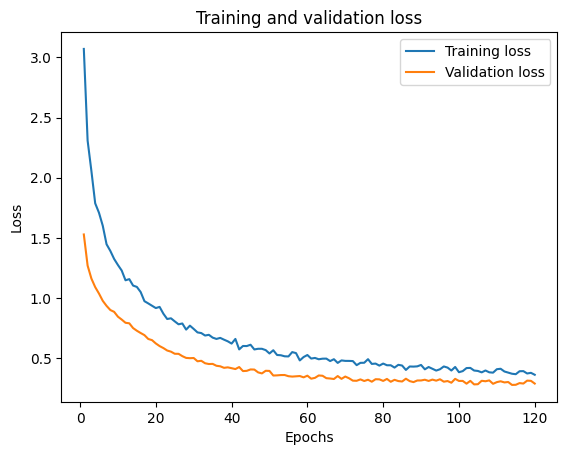

In [9]:
# Plot of training and validation loss.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Check the Test accuracy

In [10]:
# Test
test_loss, test_accuracy = model.evaluate(X_test_transformed, y_test)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9487 - loss: 0.2363
Test loss 0.2441
Test accuracy 0.9456


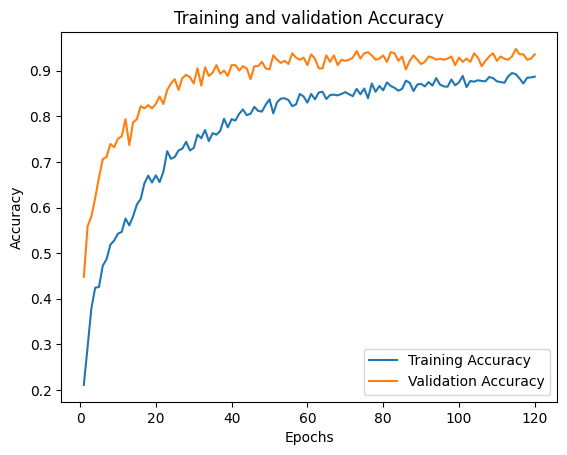

In [11]:
# Plot of training and validation accuracy over epochs.

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Hyperparameter Tuning

In [12]:
# Hyperparameter Tuning: How can we better optimize our FNN? Let us start with the basic model
# template with a custom function and test out different hyperparameters. 

def skeleton_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=3)  # Number of hidden layers
    n_neurons_layer_1 = hp.Choice("n_neurons_layer_1", values=[128, 64, 32, 16])  # Neurons for the first hidden layer
    n_neurons_layer_2 = hp.Choice("n_neurons_layer_2", values=[128, 64, 32, 16])  # Neurons for the second hidden layer
    n_neurons_layer_3 = hp.Choice("n_neurons_layer_3", values=[128, 64, 32, 16])  # Neurons for the third hidden layer (if used)
    learning_rate = hp.Choice("learning_rate", values=[0.001, 0.005, 0.01])  # 3 choices for learning rate
    optimizer = hp.Choice("optimizer", values=["Adam", "Nadam", "Adamax"])
    l2_reg = hp.Choice("l2_regularization", values=[0.001, 0.005, 0.01])  # 3 choices for L2 regularization
    dropout_rate = hp.Choice("dropout_rate", values=[0.3, 0.4, 0.5])

    if optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    
    samp_model = tf.keras.Sequential()

    # First hidden layer (connected to the input layer)
    samp_model.add(tf.keras.layers.Dense(n_neurons_layer_1, activation='selu', input_shape=(31,), kernel_regularizer=l2(l2_reg)))
    samp_model.add(tf.keras.layers.Dropout(dropout_rate))

    # Second hidden layer
    samp_model.add(tf.keras.layers.Dense(n_neurons_layer_2, activation="selu", kernel_regularizer=l2(l2_reg)))
    samp_model.add(tf.keras.layers.Dropout(dropout_rate))

    # Third hidden layer (conditionally added)
    if n_hidden == 3:
        samp_model.add(tf.keras.layers.Dense(n_neurons_layer_3, activation="selu", kernel_regularizer=l2(l2_reg)))
        samp_model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Output layer
    samp_model.add(tf.keras.layers.Dense(7, activation="softmax"))
    samp_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                       metrics=["accuracy"])
    return samp_model



In [13]:
random_search_tuner = kt.RandomSearch(
    skeleton_model, objective="val_accuracy", max_trials=25, overwrite=True,
    seed=42)
random_search_tuner.search(X_train_transformed, y_train,
                           epochs=120,
                           batch_size=32,
                           validation_data=(X_val_transformed, y_val))

Trial 25 Complete [00h 00m 10s]
val_accuracy: 0.9241706132888794

Best val_accuracy So Far: 0.9668246507644653
Total elapsed time: 00h 04m 31s


In [14]:
# After hyperparameter tuning trials, extract best hyperparameters from the RandomSearch tuner. 
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 11 summary
Hyperparameters:
n_hidden: 3
n_neurons_layer_1: 64
n_neurons_layer_2: 64
n_neurons_layer_3: 64
learning_rate: 0.005
optimizer: Adamax
l2_regularization: 0.005
dropout_rate: 0.3
Score: 0.9668246507644653


## Set up the alternative model using optimized hyperparameters

In [15]:
# Now we rerun the alternative model using the optimized hyperparameters. 

model_best = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='selu', input_shape=(31,), kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the final model.
model_best.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_best = model_best.fit(X_train_transformed, y_train, 
                    epochs=120, 
                    batch_size=32, 
                    validation_data=(X_val_transformed, y_val))

Epoch 1/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3327 - loss: 2.7951 - val_accuracy: 0.5995 - val_loss: 1.7528
Epoch 2/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 1.9454 - val_accuracy: 0.7014 - val_loss: 1.5048
Epoch 3/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5761 - loss: 1.7125 - val_accuracy: 0.7464 - val_loss: 1.3579
Epoch 4/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6249 - loss: 1.5648 - val_accuracy: 0.8175 - val_loss: 1.2384
Epoch 5/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 1.4731 - val_accuracy: 0.7915 - val_loss: 1.1732
Epoch 6/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 1.3607 - val_accuracy: 0.8294 - val_loss: 1.0884
Epoch 7/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 1.2101 - val_accuracy: 0.8531 - val_loss: 1.0162
Epoch 8/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7530 - loss: 1.1728 - val_accuracy: 0.8578 - v

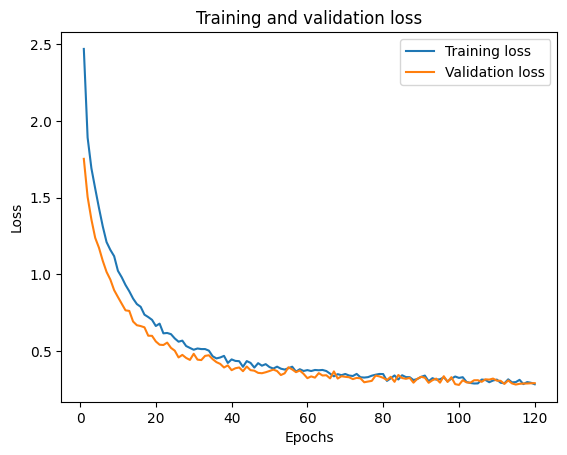

In [16]:
# Plot of training and validation loss of the final model. 

loss_best = history_best.history['loss']
val_loss_best = history_best.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss_best,  label='Training loss')
plt.plot(epochs, val_loss_best, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Check the test accuracy for the alternative model

In [17]:
# Test accuracy and loss for the final model.
test_loss, test_accuracy = model_best.evaluate(X_test_transformed, y_test)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.9661 - loss: 0.2462
Test loss 0.2532
Test accuracy 0.9669


## Reduce the epochs to 80 based on the plot

In [18]:
# Now we rerun the alternative model using the optimized hyperparameters with 60 epochs

model_best_80 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='selu', input_shape=(31,), kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='selu', kernel_regularizer=l2(0.005),
                          ),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the final model.
model_best_80.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_best_80 = model_best_80.fit(X_train_transformed, y_train, 
                    epochs=80, 
                    batch_size=32, 
                    validation_data=(X_val_transformed, y_val))

Epoch 1/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2990 - loss: 2.8628 - val_accuracy: 0.6422 - val_loss: 1.7107
Epoch 2/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 1.9513 - val_accuracy: 0.6848 - val_loss: 1.4867
Epoch 3/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5929 - loss: 1.6803 - val_accuracy: 0.7915 - val_loss: 1.3217
Epoch 4/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 1.5463 - val_accuracy: 0.7915 - val_loss: 1.2174
Epoch 5/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6786 - loss: 1.4019 - val_accuracy: 0.8389 - val_loss: 1.1154
Epoch 6/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6996 - loss: 1.2779 - val_accuracy: 0.8531 - val_loss: 1.0475
Epoch 7/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7213 - loss: 1.2408 - val_accuracy: 0.8649 - val_loss: 0.9804
Epoch 8/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 1.1144 - val_accuracy: 0.8768 - val_loss:

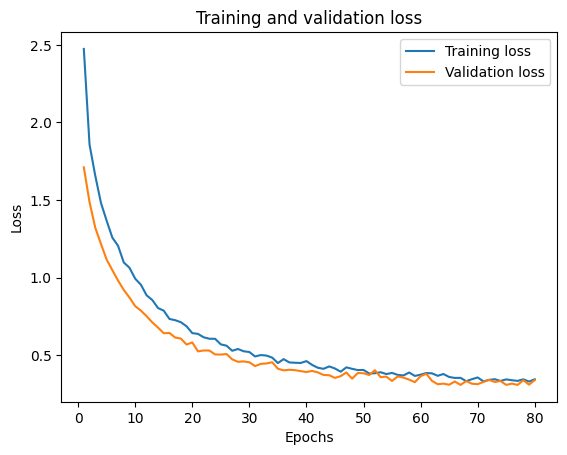

In [20]:
# Plot of training and validation loss of the final model. 

loss_best_80 = history_best_80.history['loss']
val_loss_best_80 = history_best_80.history['val_loss']

epochs = range(1, 81)

plt.plot(epochs, loss_best_80,  label='Training loss')
plt.plot(epochs, val_loss_best_80, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Check the test accuracy for the alternative model with 68 epochs

In [21]:
# Test accuracy and loss for the final model.
test_loss, test_accuracy = model_best_80.evaluate(X_test_transformed, y_test)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.9529 - loss: 0.2791
Test loss 0.2890
Test accuracy 0.9551


## Our best model is the alternative model after hyperparameter tuning with the epoch of 120. The best test accuracy is 0.9669. Based on the training process, we reduced the epochs to 80, and the test accuracy is 0.9551, which is still good. The 80-epoch model is robust to overfitting issues, while the accuracy is slightly lower than the 120-epoch one.